In [1]:
# Import necessary packages
import pandas as pd 
import os
import sys
sys.path.append('/Users/jonathanquartin/Documents/Coding/GitHub/precip-notebooks')
from helper_functions import date_to_decimal_year, rain_predictor
from plot_functions import eruption_counter, rain_plotter
from el_nino_functions import elnino_strengths
import numpy as np

In [2]:
# Create path to data
folder_path = '/Users/jonathanquartin/Documents/Coding/GitHub/um_volcano_project/GALAPAGOS_DATA'

In [3]:
# Import tables
volcanic_events = pd.read_csv(os.path.join(folder_path, "eruptions_galapagos3.csv"))
rainfall = pd.read_csv(os.path.join(folder_path, "cleaned_precip_galap.csv"))

bellavista = pd.read_csv(os.path.join(folder_path, "climate_bellavista.csv"))
ayora = pd.read_csv(os.path.join(folder_path, "climate_puerto-ayora.csv"))

oni = pd.read_csv(os.path.join(folder_path, "oni.csv"))

Eruption data must have columns: 'Volcano' and 'Start'. 'Start' is the beginning date of the eruption given as a string-- YYYY-MM-DD.

Rainfall data must have columns: 'Date', 'Longitude', 'Latitude', and 'Precipitation'. 'Date' is given as a string YYYY-MM-DD and the other three columns are floats.

In [4]:
sites_dict = {'Wolf': (-91.35, .05, 'Wolf'), 'Fernandina': (-91.55, -.35, 'Fernandina'), 'Negra, Sierra': (-91.15, -.85, 'Sierra Negra'), 'Azul, Cerro': (-91.35, -.95, 'Cerro Azul')} # Long/lat pairs must exist in rainfall data
quantiles = 2 # Number of bins to break up rainfall into
rolling_number = 90 # Number of days to average rainfall over
log_flag = True # If true, applies a log scaling to the data
by_season = False # Make true if you want to consider rainfall quantiles yearly, or False to consider rainfall quantiles across the entire date range

# Uses the elnino_strengths function to get all instances of el ninos and la ninas
start = min(rainfall['Date'])
end = max(rainfall['Date'])
strengths = {}
anom_types = {'weak nina': -.5, 'moderate nina': -1, 'strong nina': -1.5, 'weak nino': .5, 'moderate nino': 1, 'strong nino': 1.5, 'very strong nino': 2}
for i in anom_types:
    if i == 'weak nina' or i == 'weak nino':
        strengths.update(elnino_strengths(oni, anom_types[i], i, 5))
    else:
        strengths.update(elnino_strengths(oni, anom_types[i], i, 3)) 

# Uncomment below to use rain predictor gauge location. (For analyses of eruptions between 1964 and 2000)

compare_site = ayora  # Choose ayora or bellavista to compare rainfall to
print_summary = False # Make true if you want to see summary of regression
pred_rain = rain_predictor(rainfall, sites_dict, compare_site, rolling_number, print_summary)
rainfall_two = pred_rain[pred_rain['Date'] < start].copy()
rainfall = pd.concat([rainfall, rainfall_two])
start = min(rainfall['Date'])
end = max(rainfall['Date'])

# Picks out elninos/laninas between the start and end dates. Converts dates to decimals.
elninos = {'weak nina': [], 'moderate nina': [], 'strong nina': [], 'weak nino': [], 'moderate nino': [], 'strong nino': [], 'very strong nino': []}

if strengths != None:
    for j in strengths:
        for i in strengths[j]:
            if i[1] > start and i[0] < end:
                first = max(i[0], start)
                last = min(i[1], end)
                elninos[j].append([date_to_decimal_year(first), date_to_decimal_year(last)])



We look at rolling averages of rainfall at each volcano site. We group dates at each volcano into quantiles based on the rolling rain averages. In gray, we've included the cumulative precipitation.

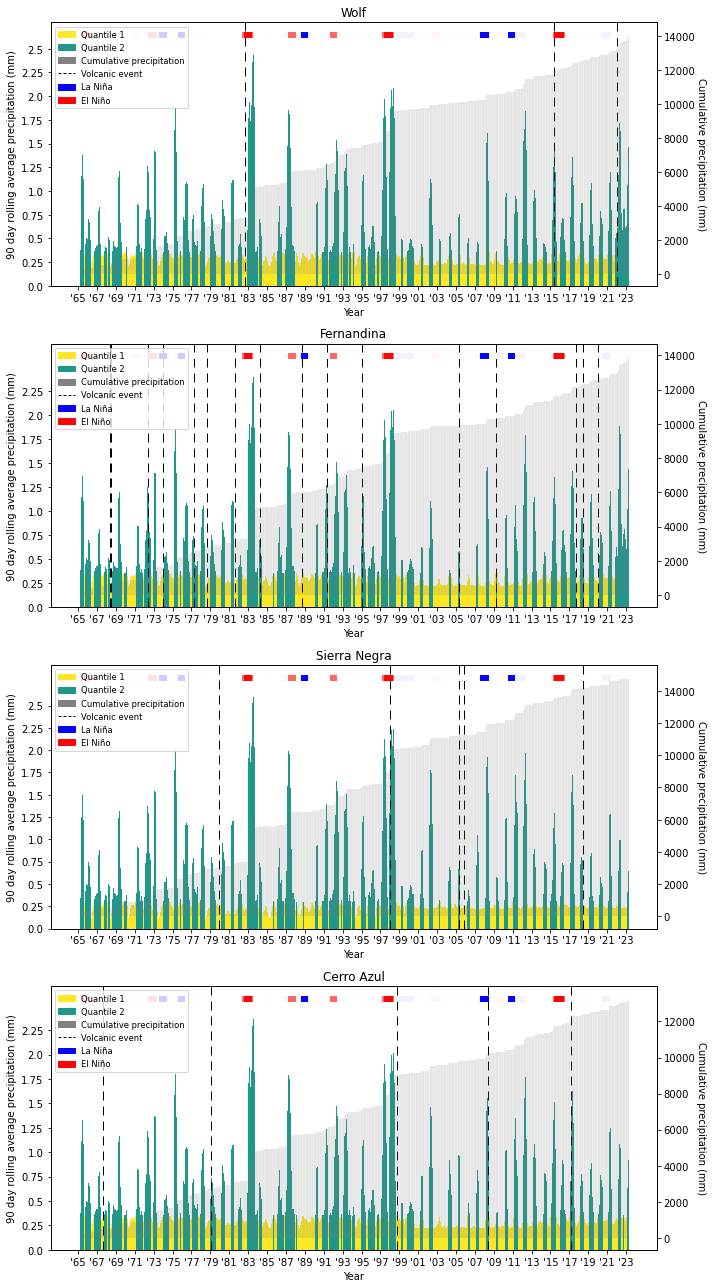

In [5]:
plot_type = 'bar'

rain_plotter(plot_type ,sites_dict, rainfall, quantiles, rolling_number, volcanic_events, by_season, log_flag, elninos)

Below we break up eruptions into quantiles, first all together, and then by individual volcano.

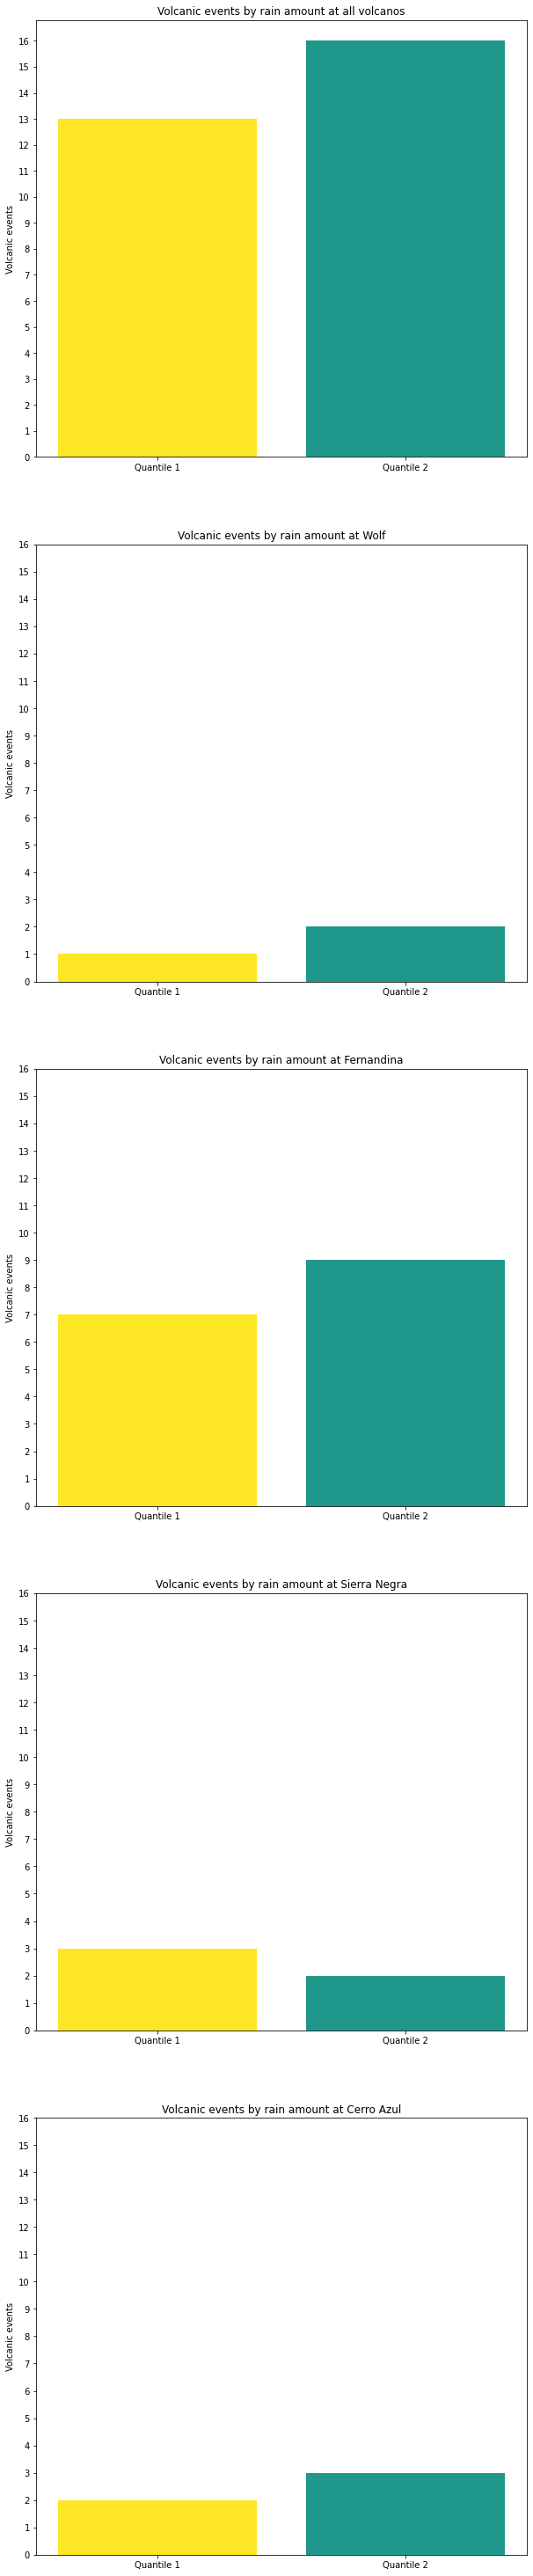

In [6]:
vals = eruption_counter(sites_dict, volcanic_events, rainfall, quantiles, rolling_number, by_season)

Below, we plot rainfall at the volcano sites by year.

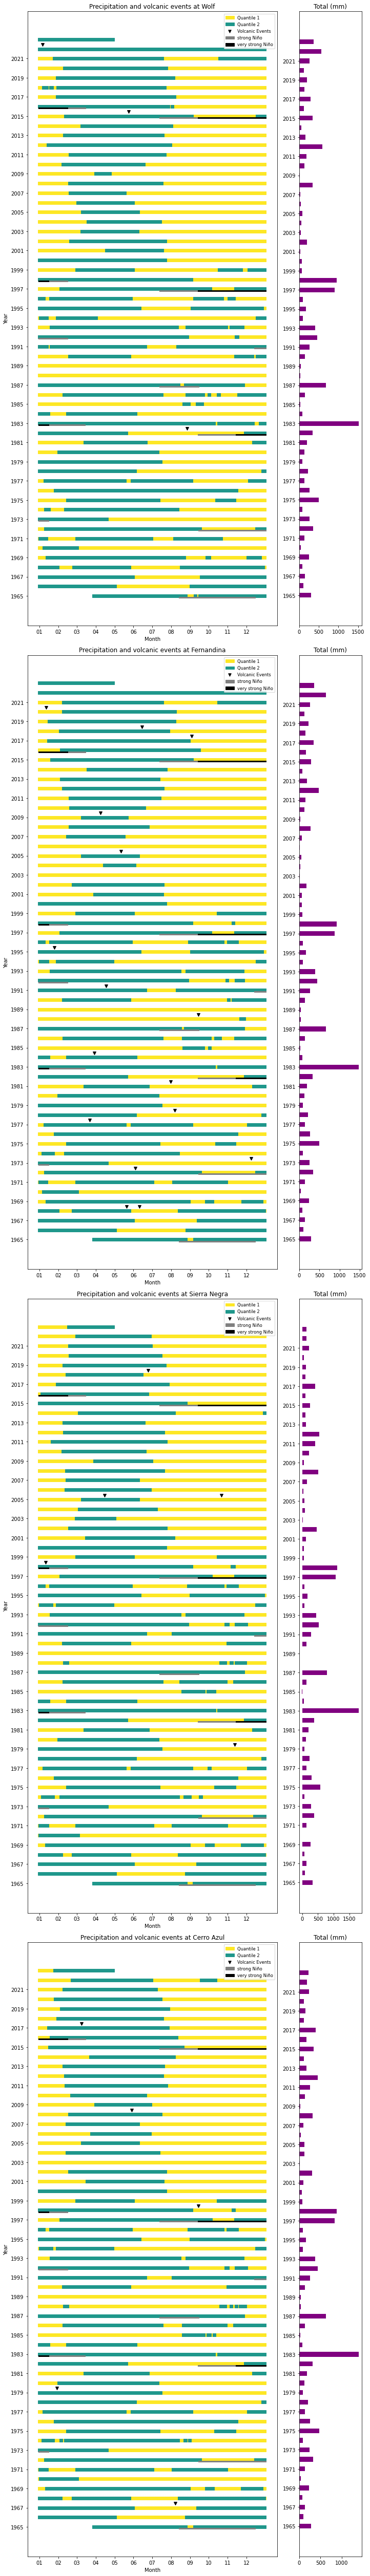

In [7]:
plot_type = 'annual'

rain_plotter(plot_type, sites_dict, rainfall, quantiles, rolling_number, volcanic_events, by_season=False, log_flag=True, elninos=elninos)